---
title: "Quantum Approximate Optimization Algorithm (QAOA) from scratch"
author: "Marcin Płodzień"
toc: true
number-sections: true
highlight-style: pygments
jupyter: python3
skip_showdoc: true
skip_exec: true
---

The QAOA algorithm is a quantum algorithm used to solve optimization problems by finding an extremum of a given cost function. The QAOA was first introduced by E. Farhi, J. Goldstone, and S. Gutmann in [A Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028). The algorithm has been shown to be efficient for solving certain types of optimization problems, such as Max-Cut problem, which is NP-hard.

In the following we will implement QAOA for Max-Cut problem from scratch using Pytorch and its automatic differentiation libraries.

## Max-Cut problem introduction

Max-Cut is a classic optimization problem in computer science and mathematics, where the goal is to divide a graph into two sets, such that the sum of weights of the edges connecting vertices in different sets is maximized. It is a NP-hard problem, meaning it is difficult to solve for large graphs in a reasonable amount of time using classical algorithms.

In the Max-Cut problem, a graph is represented by a set of vertices (nodes) and edges (connections) between the vertices. Each edge has a weight representing the cost of cutting that edge. The goal is to find a way to divide the vertices into two sets such that the sum of the weights of the edges connecting vertices in different sets is maximized.

The Max-Cut problem is important in many real-world applications, such as image segmentation, clustering, and community detection in networks. 

It has been shown that the QAOA algorithm can be applied to the Max-Cut problem, providing a quantum-inspired solution to the problem. The efficiency of the QAOA algorithm for solving Max-Cut problems is still being explored and it is an active area of research.

Let us consider a planar graph $G = (V,E)$, having vertices (or nodes) enumerated by index $i \in V$, and edges being a connected pars of vertices, i.e. $E = \{ (i,k) | i,k\in V, i\ne k\}$. Each edges carries a weigth $w_{ik}>0$. We consider undirected graph, thus $w_{ik} = w_{ki}$. 

We prepare \textit{a cut} of a graph $G$, i.e. we divide graph $G$ into two parts $S$, $T$ such that $V = S\cup T$. To each node belonging to subgraph $S$ we assign value $z_i = +1$, while to each node in subgraph $T$ we assing value of $z_i = -1$. To check if two nodes belong to the same part, we can define a function
\begin{equation}
 c_{ik} = \frac{1-z_iz_k}{2},
\end{equation}
which takes value $0$ if two nodes $i,k$ belong to the same subset, are $1$ if nodes belong to different subsets.

Finally, we can define a $\textit{value of a cut}$ as
\begin{equation}
  P = \sum_{i,k} c_{ik}w_{ik}.
\end{equation}

The Max-Cut is a problem of finding such a $\textit{cut}$ of a graph, which maximizes $P$. We can write
\begin{equation}
 P = \sum_{i<k}w_{ik} - \sum_{i<k}w_{ik}z_iz_k = W - C(\vec{z}),
\end{equation} 
where $W = \sum_{i<k}w_{ik}$ is a positive constant number, and $C(\vec{z}) = \sum_{i<k}w_{ik}z_iz_k$ is a cost function which we want to minimize.


## Max-Cut problem expressed as a spin-1/2 problem

The Max-Cut problem can be cast to solving a quantum mechanical problem of spin-1/2 system. To the $i$-th node with the value $z_i1$ we assign the state of the spin-1/2, i.e.:

\begin{equation}
 \begin{split}
    z = +1 \to & |0\rangle \equiv |\uparrow\rangle \\ 
    z = -1 \to & |1\rangle \equiv |\downarrow\rangle.
 \end{split}
\end{equation}
As such, minimizing the cost function $C(\vec{z})$ can be considered as fidning the spin configuration which minimizes the $\textit{cost Hamiltonian}$, defined as:

\begin{equation}
 \hat{H}_C = \sum_{ik} w_{ik} \hat{\sigma}^z_i\hat{\sigma}^z_k,
\end{equation}
where $\hat{\sigma}^z_i$ is a Pauli-Z matrix acting on $i$-th qubit.

While we consider planar graph, and enumerate spins with index $i$, the problem is equivalent to consider one-dimensional chain of spins, properly connected via edges.
For simplicity, let's consider a simple two dimmensional grid of size $L_x \times L_y$, where a each node of the grid we $(i_x, i_y)$ have one spin-$1/2$, and $i_x = 1,\dots,L_x$, $i_y = 1,\dots,L_y$. We assume $w_{ik} = 1$ where two spins are nearest neighbors, and $w_{ik}=0$ otherwise.

Next, to each spin at node $(i_x,i_y)$ we can assign a label $i \equiv (i_y - 1)L_x + i_x$, , i.e. $(i_x, i_y) \to i$. With such a mapping, our original 2-dimensional problem, can be cast to 1-dimensional problem with $L = L_x L_y$ spins-$1/2$, where total Hilbert space has size ${\cal D} = 2^{L}$.

The Quantum Approximate Optimization Algorithm is based on a specific form of an ansatz for optimal many-body wave function $|\psi_*\rangle$ minimizing the cost Hamiltonian $\hat{H}_C$. The optimal parameters of an ansatz are obtained in an iterative procedure.

## QAOA ansatz

The QAOA ansatz for the many-body wave-function providing optimal spin configuration minimizing the cost Hamiltonian $\hat{H}_C$ has the following form:

\begin{equation}
 |\psi(\vec{\beta},\vec{\gamma}\rangle = U_B(\beta_1)U_C(\gamma_1)\dots U_B(\beta_p)U_C(\gamma_p)|s\rangle,
\end{equation}

where an initial state $|s\rangle$ is coherent superposition on spin up/down configuration for each qubit. State $|s\rangle$ is generated via acting with the Hadamard operator on $i$-th qubit:
\begin{equation}
    |s\rangle = \sum_{i=1}^{L} H_i|0\rangle \equiv  \sum_{i=1}^{L} H_i|\uparrow\rangle.
\end{equation}

The variational vectors $\vec{\beta} = (\beta_1,\dots,\beta_p)$, and $\vec{\gamma} = (\gamma_1,\dots,\gamma_p)$ parametrize two unitaries:
\begin{equation}
 \begin{split}
   U_B(\beta_l) & = e^{-i\beta_l \hat{H}_B},\\
   U_C(\gamma_l) & = e^{-i\gamma_l \hat{H}_C},
 \end{split}
\end{equation}
where $\hat{H}_C$ is our cost Hamiltonian, and $\hat{H}_B = \sum_{i} \hat{\sigma}^x_i$ is called a $\textit{mixer Hamiltonian}$. The number of variational coeficients $p$ is a hyperparameter for the QAOA.

In the QOAO  we iteratively update parameters $\vec{\beta}$, and $\vec{\gamma}$ in order to minimize the cost function, i.e. expectation value of the cost Hamiltonian:
\begin{equation}
F(\vec{\beta},\vec{\gamma}) = \langle\psi(\vec{\beta},\vec{\gamma})|\hat{H}_C|\psi(\vec{\beta},\vec{\gamma})\rangle.
\end{equation}
The optimization procedure can be done with the help of automatic differentiation.

After finding the optimal set of parameters $\vec{\beta}_*$, $\vec{\gamma}_*$ defining the many-body wave function
\begin{equation}
 |\psi_*\rangle\equiv |\psi(\vec{\beta}_*,\vec{\gamma}_*)\rangle,
\end{equation}
the optimal spin configuration for our problem corresponds to index $k$ of the Fock vector from our basis, for which the quantity
\begin{equation}
 |\langle v_k|\psi_*\rangle|^2
\end{equation}
is maximal, where $|v_k\rangle$ is a Fock vector of the $L$-qubit Hilbert space:
\begin{equation}
 \begin{split}
   |v_1\rangle & = |\uparrow \uparrow \dots \uparrow \rangle \\
   |v_2\rangle & = |\uparrow \uparrow \dots \downarrow \rangle \\
   & \vdots \\
   |v_D\rangle & = |\downarrow \downarrow \dots \downarrow \rangle \\
 \end{split}
\end{equation}
 In the following we denote: $\uparrow \equiv 1$, $\downarrow \equiv -1$.

Finally, we repeat the optimization procedure $N$ times, and we plot histogram of the optimal spin configuration indexed by $k$. In the limit of $N\to\infty$ the most probable spin configuration is the solution to our classical optimization problem.

> For small number of nodes $L$ the QAOA is not needed: we can simply diagonalize cost Hamiltonian $\hat{H}_C$, and find the spin configuration which minimizes cost function. However for $L \le 25$ this brute-force approach fails due to exponential increase of the corresponding Hilbert space ${\cal D} = 2^L$

## QAOA implementation in Pytorch

### Pauli spin chain operators

The starting point is to implement the Pauli spin chain operators. On a spin-$1/2$ chain with $L$ spins, the Pauli spin operators $X_i,Y_i,Z_i$ acting on $i$-th spin are defined as:
\begin{equation}
 \begin{split}
 X_i  &= \mathbb{1}_1\otimes\dots\mathbb{1}_{i-1}\otimes\hat{\sigma}^x\otimes\mathbb{1}_{i+1}\dots\mathbb{1}_{L},\\
 Y_i  &= \mathbb{1}_1\otimes\dots\mathbb{1}_{i-1}\otimes\hat{\sigma}^y\otimes\mathbb{1}_{i+1}\dots\mathbb{1}_{L},\\
 Z_i  &= \mathbb{1}_1\otimes\dots\mathbb{1}_{i-1}\otimes\hat{\sigma}^z\otimes\mathbb{1}_{i+1}\dots\mathbb{1}_{L},
 \end{split}
\end{equation}
where $\hat{\sigma}^{x,y,z}$ are $2\times2$ Pauli operators.

In a similar manner we can define Hadamard matrix $H_i$ acting on $i$-th spin, i.e.
\begin{equation}
H_i = \mathbb{1}_1\otimes\dots\mathbb{1}_{i-1}\otimes H\otimes\mathbb{1}_{i+1}\dots\mathbb{1}_{L},
\end{equation}
where $H = \frac{\hat{\sigma}^x + \hat{\sigma}^z}{\sqrt{2}}$.

Let's import necessary librarires and define Pauli operators, and Hadamard operator, on a spin chain of lenght $L=L_x\times L_y$. We consider $L_x = L_y = 3$:

In [ ]:
import matplotlib.pyplot as plt
import torch as pt
from torch import matrix_exp as expm
from torch.linalg import eigh as eigh
import numpy as np

def get_linear_index(i_x, i_y):
    return  (i_y-1)*Lx + i_x

def get_Identity(k):  # returns k-tensor product of the identity operator, ie. Id^k
    Id = id_local
    for i in range(0, k-1):
        Id = pt.kron(Id, id_local)
    return Id
         
def get_string_operator(A, L, i):
    Op = A
    if(i == 1):
        Op = pt.kron(A,get_Identity(L-1))
        return Op
    if(i == L):
        Op = pt.kron(get_Identity(L-1),A)
        return Op
    if(i>0 and i<L):
        Op = pt.kron(get_Identity(i-1), pt.kron(Op, get_Identity(L-i)))
        return Op
    
id_local = pt.tensor([[1.,0],[0,1.]])
sigma_x = pt.tensor([[0,1.],[1.,0]])
sigma_y = 1j*pt.tensor([[0,-1.],[1.,0]])
sigma_z = pt.tensor([[1.,0],[0,-1.]])
hadamard = 1.0/pt.sqrt(pt.tensor(2))*pt.tensor([[1,1],[1,-1]])+1j*0    


Lx = 3
Ly = 2
L = Lx*Ly
D = 2**L
Id = get_string_operator(id_local, L, 1)
X = {}
Y = {}
Z = {}
Hadamard = {}


for qubit_i_y in range(1, Ly+1):    # Loop over indices on a 2-dimensional grid (i_x,i_y)
    for qubit_i_x in range(1,Lx+1): #
        qubit_i = get_linear_index(qubit_i_x, qubit_i_y)
        X[qubit_i] = get_string_operator(sigma_x, L, qubit_i)        # Define operator X_i acting on spin (i_x,i_y)
        Y[qubit_i] = get_string_operator(sigma_y, L, qubit_i)        # Define operator Y_i acting on spin (i_x,i_y)
        Z[qubit_i] = get_string_operator(sigma_z, L, qubit_i)        # Define operator Z_i acting on spin (i_x,i_y)
        Hadamard[qubit_i] = get_string_operator(hadamard, L, qubit_i)# Define operator H_i acting on spin (i_x,i_y)

As we mentioned above, all operators are expressed in the diagonal basis of the $Z = \sum_{i=1}^{L} Z_i$ operator, i.e.

\begin{equation}
\begin{split}
   X & = \sum_{k,l} <v_k|X|v_l>|v_k\rangle\langle v_l| \\
   Y & = \sum_{k,l} <v_k|Y|v_l>|v_k\rangle\langle v_l| \\
   Z & = \sum_{k,l} <v_k|Z|v_l>|v_k\rangle\langle v_l| \delta_{k,l},
\end{split}
\end{equation}
and
\begin{equation}
 \begin{split}
   |v_1\rangle & = |\uparrow \uparrow \dots \uparrow \rangle \\
   |v_2\rangle & = |\uparrow \uparrow \dots \downarrow \rangle \\
   & \vdots \\
   |v_D\rangle & = |\downarrow \downarrow \dots \downarrow \rangle \\
 \end{split}
\end{equation}

In the following we denote: $\uparrow \equiv 1$, $\downarrow \equiv -1$.

Let's us construct our Hilbert space:

In [ ]:
D = 2**L
basis = pt.zeros((D,L)) 
for v_i in range(0,D):
    fock_state = pt.zeros(D) 
    fock_state[v_i] = 1
    for i in range(1,L+1):
        basis[v_i,i-1] = pt.vdot(fock_state, Z[i]@fock_state)

for v_i in range(0,D):  
    string_fock_vector = "|v_" + "{:03d}".format(v_i) + "> = |"
    for i in range(1,L+1):
        tmp = int(basis[v_i,i-1].item())
        if(tmp==1):
            string_plus_minus = " {:1d}".format(tmp)
        if(tmp==-1):
            string_plus_minus = "{:1d}".format(tmp)
            
         
        string_fock_vector = string_fock_vector + string_plus_minus + " "
    string_fock_vector = string_fock_vector + ">"
    print(string_fock_vector)


|v_000> = | 1  1  1  1  1  1 >
|v_001> = | 1  1  1  1  1 -1 >
|v_002> = | 1  1  1  1 -1  1 >
|v_003> = | 1  1  1  1 -1 -1 >
|v_004> = | 1  1  1 -1  1  1 >
|v_005> = | 1  1  1 -1  1 -1 >
|v_006> = | 1  1  1 -1 -1  1 >
|v_007> = | 1  1  1 -1 -1 -1 >
|v_008> = | 1  1 -1  1  1  1 >
|v_009> = | 1  1 -1  1  1 -1 >
|v_010> = | 1  1 -1  1 -1  1 >
|v_011> = | 1  1 -1  1 -1 -1 >
|v_012> = | 1  1 -1 -1  1  1 >
|v_013> = | 1  1 -1 -1  1 -1 >
|v_014> = | 1  1 -1 -1 -1  1 >
|v_015> = | 1  1 -1 -1 -1 -1 >
|v_016> = | 1 -1  1  1  1  1 >
|v_017> = | 1 -1  1  1  1 -1 >
|v_018> = | 1 -1  1  1 -1  1 >
|v_019> = | 1 -1  1  1 -1 -1 >
|v_020> = | 1 -1  1 -1  1  1 >
|v_021> = | 1 -1  1 -1  1 -1 >
|v_022> = | 1 -1  1 -1 -1  1 >
|v_023> = | 1 -1  1 -1 -1 -1 >
|v_024> = | 1 -1 -1  1  1  1 >
|v_025> = | 1 -1 -1  1  1 -1 >
|v_026> = | 1 -1 -1  1 -1  1 >
|v_027> = | 1 -1 -1  1 -1 -1 >
|v_028> = | 1 -1 -1 -1  1  1 >
|v_029> = | 1 -1 -1 -1  1 -1 >
|v_030> = | 1 -1 -1 -1 -1  1 >
|v_031> = | 1 -1 -1 -1 -1 -1 >
|v_032> 

### Cost and mixer Hamiltonians

Our cost Hamiltonian for Max-Cut problem has the following form:

\begin{equation}
 \hat{H}_C = -\frac{1}{2}\sum_{\langle i,j\rangle} Z_i Z_j,
\end{equation}

where $\langle i,j\rangle$ means sum over nearest neighbors. Note, that each node $i$ has two coordinates, i.e. $ i \equiv (i_x, i_y)$:

In [ ]:
H_C = pt.zeros((D,D)) + 0*1j
for qubit_i_x in range(1,Lx+1):
    for qubit_i_y in range(1,Ly+1):
        qubit_i = get_linear_index(qubit_i_x,qubit_i_y)
        for qubit_j_x in range(1,Lx+1):
            for qubit_j_y in range(1,Ly+1):
                qubit_j = get_linear_index(qubit_j_x,qubit_j_y)
                # Sum over nearest neighbors only
                if(np.abs(qubit_i_x - qubit_j_x)==1 and np.abs(qubit_i_y - qubit_j_y)==0):
                    H_C = H_C - Z[qubit_i]@Z[qubit_j]
                if(np.abs(qubit_i_x - qubit_j_x)==0 and np.abs(qubit_i_y - qubit_j_y)==1):
                    H_C = H_C - Z[qubit_i]@Z[qubit_j]
H_C = 0.5*H_C                    

The mixer Hamiltonian has the following form:

\begin{equation}
\hat{H}_B = \sum_i X_i
\end{equation}

In [ ]:
H_B = pt.zeros((D,D)) + 0*1j
for qubit_i_x in range(1,Lx+1):
    for qubit_i_y in range(1,Ly+1):
        qubit_i = get_linear_index(qubit_i_x,qubit_i_y)
        H_B = H_B + X[qubit_i]

Finally, we can define two unitary evolution operators for cost, and mixer Hamiltonians, parametrized by $\gamma$ and $\beta$

\begin{equation}
\begin{split}
 U_B(\beta) & = e^{-i\beta \hat{H}_B} \\
 U_C(\gamma) & = e^{-i\gamma \hat{H}_C}.
\end{split}
\end{equation}

In [ ]:
def U_B(H_B,beta):
    return expm(-1j*beta*H_B)

def U_C(H_C,gamma):
    return expm(-1j*gamma*H_C) 

### QAOA ansatz

Finally, we can define the QAOA ansatz, parametrized by two set of parameters, $\vec{\beta}$, and $\vec{\gamma}$, having $p$ elements:
\begin{equation}
 |\psi(\vec{\beta},\vec{\gamma})\rangle = \prod_{l = 1}^p U_B(\beta_l)U_C(\gamma_l)|s\rangle,
\end{equation}
where state $|s\rangle$ is coherent superposition of states $|0\rangle$ adn $|1\rangle$ of each qubit, i.e.
\begin{equation}
 |s\rangle = \prod_{i = 1}^{L} H_i|0\rangle,
\end{equation}
where $H_i$ is Hadamard matrix acting on $i$-th qubit initialized in $|0\rangle$ state.

Length $p$ of vectors $\vec{\beta}$, and $\vec{\gamma}$ is one of the hyperparameters in $QAOA$ anstaz:

In [ ]:
def psi(parameters):
    beta_vec  = parameters[0,:]
    gamma_vec = parameters[1,:]
    psi_tmp = pt.zeros(D) + 0*1j
    psi_tmp[0] = 1 # in basis of total Z operator Z = \sum_i Z_i this elements corresponds  
                   # to configurations with all spins pointing up
   
    # prepare Hadamard operation on each qubit
    for qubit_i_x in range(1,Lx+1):
        for qubit_i_y in range(1,Ly+1):
            qubit_i = get_linear_index(qubit_i_x,qubit_i_y)
            psi_tmp = Hadamard[qubit_i]@psi_tmp
    
    for i in range(0,p):
        psi_tmp = U_C(H_C, gamma_vec[i])@psi_tmp
        psi_tmp = U_B(H_B, beta_vec[i])@psi_tmp
    
    return psi_tmp

Finally, we define a cost function as a expectation value of the cost Hamilonian $F(\vec{\beta},\vec{\gamma}) = \langle \psi(\vec{\beta},\vec{\gamma})|\hat{H}_C|\psi(\vec{\beta},\vec{\gamma})\rangle$:

In [ ]:
def F(parameters):
    return pt.vdot(psi(parameters), H_C@psi(parameters)).real

### Optimization loop
In the optimization loop we choose number of layers $p$, and initialize the $\vec{\beta}$, and $\vec{\gamma}$ as a random numbers. Next, with the help of automatic differentiation we find set of parameters which minimizes the expectation value of the cost Hamiltonian $\hat{H}_C$. When we find the optimal set of parameters, our solution to the problem (i.e. spin configuration) corresponds to the fock state with the maximal probability of the final wave-function, i.e. $v_{\rm optimal} = argmax(\rho)$

In [ ]:
p = 2
parameters = pt.rand((2,p),requires_grad=True)   # first row corresponds to (beta_1,...,beta_p)
                                                 # second row corresponds to (gamma_1,...,gamma_p)
optimizer = pt.optim.Adam([parameters],lr = 1e-2)
loss_vs_epoch = []
for i in range(0,100):
    loss = F(parameters)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_vs_epoch.append(loss.item())

psi_optimal = psi(parameters)
rho = np.abs(psi_optimal.detach().numpy())**2
i_optimal = np.argmax(rho)
print('Optimal spins configuration after single run corresponds to basis vector with index k = ' + str(i_optimal))

Optimal spins configuration after single run corresponds to basis vector with index k = 0


Finally, we have to repeat an optimization procedure and make histogram of optimal configurations.

Text(0, 0.5, 'Probability')

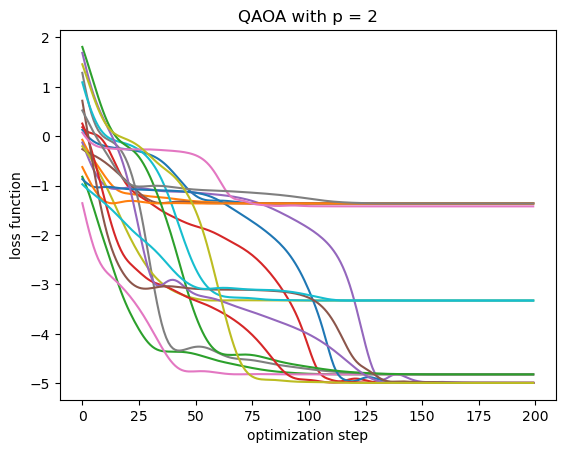

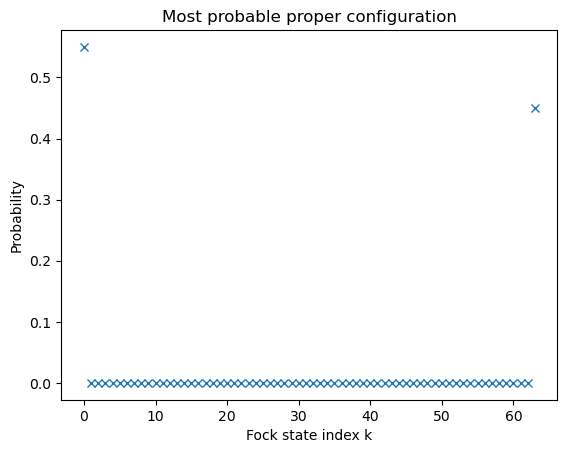

In [ ]:
N_runs = 20
fig, ax = plt.subplots(1,1)
histogram = np.zeros(D)
for run in range(0,N_runs):
    parameters = pt.rand((2,p),requires_grad=True)
    optimizer = pt.optim.Adam([parameters],lr = 1e-2)
    loss_vs_epoch = []
    for i in range(0,200):
        loss = F(parameters)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_vs_epoch.append(loss.item())
    ax.plot(loss_vs_epoch, label = "#run = " + str(run))
    ax.set_xlabel("optimization step")
    ax.set_ylabel("loss function")
    ax.set_title("QAOA with p = " + str(p))
    if(N_runs<11):
        ax.legend()
    psi_optimal = psi(parameters)
    rho = np.abs(psi_optimal.detach().numpy())**2
    histogram[np.argmax(rho)] += 1
    
fig = plt.figure()
plt.title("Most probable proper configuration")
plt.plot(histogram/np.sum(histogram),'x')
plt.xlabel("Fock state index k")
plt.ylabel("Probability")    

From the histogram above we see that we have two solutions of our problem corresponding to configurations with all spins pointing up or down.

# Summary

In the provided example we went step-by-step through the QAOA algorithm to find a solution to a classical Max-Cut problem which is NP-hard.